In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers


2023-02-09 16:34:45.452294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 16:34:45.452360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mike/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/Downloads/archive(33)/train-cat-rabbit",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1600 files belonging to 2 classes.


2023-02-09 16:35:32.992180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 16:35:32.992217: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 16:35:32.992253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mike-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


In [5]:
train_ds.class_names

['cat', 'rabbit']

In [16]:
for image, label in train_ds.take(1):
    image = image[0]
    label = label[0]


In [17]:
image.shape

TensorShape([180, 180, 3])

In [19]:
label.numpy()

1

### preprocesing

In [20]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])


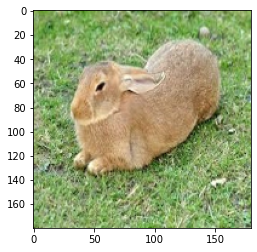

In [21]:
result = resize_and_rescale(image)
_ = plt.imshow(result)


In [22]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### data augmentation

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [24]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

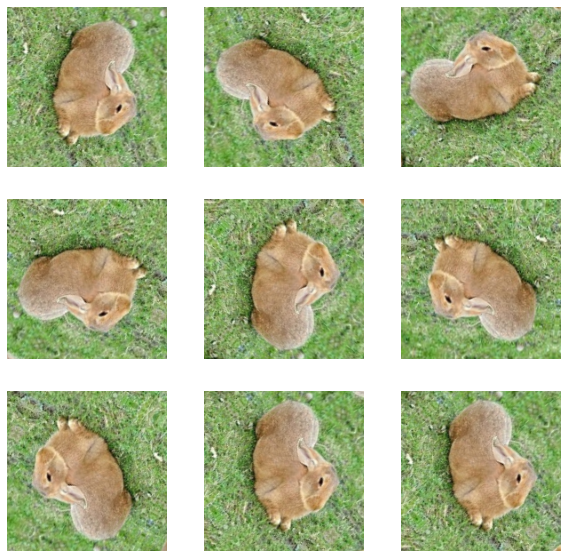

In [26]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype('uint'))
  plt.axis("off")


###  Make the preprocessing layers part of your model

In [27]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])


### Apply the preprocessing layers to your dataset

In [28]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))


### Apply the preprocessing layers to the datasets

In [29]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [31]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
# val_ds = prepare(val_ds)
# test_ds = prepare(test_ds)


ValueError: in user code:

    File "/tmp/ipykernel_118027/3731016401.py", line 17, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    File "/home/mike/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/mike/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/preprocessing/image_preprocessing.py", line 392, in call
        raise ValueError('Image augmentation layers are expecting inputs to be '

    ValueError: Exception encountered when calling layer "random_flip" (type RandomFlip).
    
    Image augmentation layers are expecting inputs to be rank 3 (HWC) or 4D (NHWC) tensors. Got shape: (None, None, 180, 180, 3)
    
    Call arguments received by layer "random_flip" (type RandomFlip):
      • inputs=tf.Tensor(shape=(None, None, 180, 180, 3), dtype=float32)
      • training=True


In [36]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])


In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [40]:
# epochs=5
# history = model.fit(
#   train_ds.unbatch(),
# #   validation_data=val_ds,
#     validation_split=0.2,
#   epochs=epochs
# )


### Custom data augmentation

In [41]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x


In [42]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()


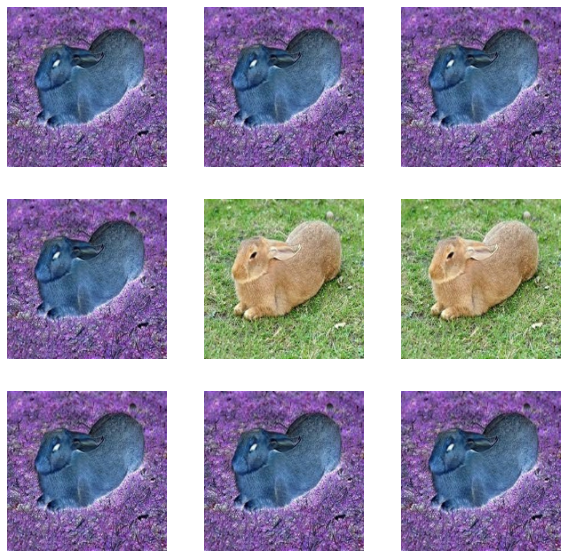

In [43]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")


### Next, implement a custom layer by subclassing:

In [44]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)


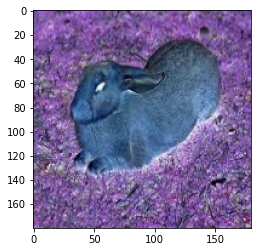

In [46]:
_ = plt.imshow(RandomInvert()(image)[0].numpy().astype('uint'))


### Using tf.image

In [48]:
# (train_ds, val_ds, test_ds), metadata = tfds.load(
#     'tf_flowers',
#     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#     with_info=True,
#     as_supervised=True,
# )


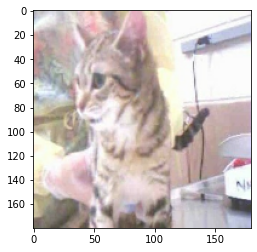

In [56]:
# image, label = next(iter(train_ds))
_ = plt.imshow(image[0].numpy().astype('uint'))
# _ = plt.title(label)


In [61]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented.numpy().astype('uint'))


### Data augmentation

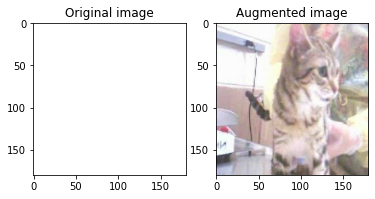

In [62]:
flipped = tf.image.flip_left_right(image[0])
visualize(image[0], flipped)
